In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Map product data from USFS Tree Canopy Cover: https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD_RELEASES_2021_REL_TCC_v2021-4
# Ground truth points were manually labeled for tree cover
data = pd.read_csv('data/tree_cover_lin_reg_1k_ground_truth_final.csv')
data['Ground Truth Tree Cover'] = data['label']*10
data['ML Tree Cover 2021'] = data['NLCD_Percent_Tree_Canopy_Cover']
data = data.dropna(subset=['aridity_index', 'elevation', 'slope'])
print(len(data))

983


In [3]:
# More map product points (USFS Tree Canopy Cover) exported from GEE
unlabeled_data = pd.read_csv('data/tree_cover_ml_points.csv')
unlabeled_data = unlabeled_data.dropna(subset=['aridity_index', 'elevation', 'slope'])
unlabeled_data['ML Tree Cover 2021'] = unlabeled_data['NLCD_Percent_Tree_Canopy_Cover']
print(len(unlabeled_data))

983238


In [4]:
covariates = ['aridity_index', 'elevation', 'slope']

# Linear regression coefficient estimation

In [5]:
Y = np.array(data["Ground Truth Tree Cover"])
Yhat = np.array(data["ML Tree Cover 2021"])
X = np.array(data[covariates])

Yhat_unlabeled = np.array(unlabeled_data['ML Tree Cover 2021'])
X_unlabeled = np.array(unlabeled_data[covariates])

In [6]:
def run_ppi_linear_regression(X, Y, Yhat, X_unlabeled, Yhat_unlabeled, alpha):
    # Run prediction-powered inference and classical inference 
    results = []
    # Prediction-Powered Inference
    rand_idx1 = np.random.RandomState(seed=0).permutation(Y.shape[0])
    _Yhat = Yhat[rand_idx1]
    _Y = Y[rand_idx1]
    _X = X[rand_idx1]

    rand_idx2 = np.random.RandomState(seed=0).permutation(Yhat_unlabeled.shape[0])
    _Yhat_unlabeled = Yhat_unlabeled[rand_idx2]
    _X_unlabeled = X_unlabeled[rand_idx2]

    ppi_ci = ppi_ols_ci(
        _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
    )

    # Classical interval
    classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

    # Append results
    results += [
        pd.DataFrame(
            [
                {
                    "method": "PPI",
                    "n": np.nan,
                    "lower": ppi_ci[0],
                    "upper": ppi_ci[1],
                    "trial": np.nan,
                }
            ]
        )
    ]
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Classical",
                    "n": np.nan,
                    "lower": classical_ci[0],
                    "upper": classical_ci[1],
                    "trial": np.nan,
                }
            ]
        )
    ]

    # Imputed CI
    
    imputed_ci = classical_ols_ci(_X_unlabeled, _Yhat_unlabeled, alpha=alpha)
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Imputation",
                    "n": np.nan,
                    "lower": imputed_ci[0],
                    "upper": imputed_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

In [7]:
df = run_ppi_linear_regression(X, Y, Yhat, X_unlabeled, Yhat_unlabeled, alpha=0.05)

# Visualize all results

In [8]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=32)          
plt.rc('axes', titlesize=32)     
plt.rc('axes', labelsize=32)    
plt.rc('xtick', labelsize=32)    
plt.rc('ytick', labelsize=32)    
plt.rc('figure', titlesize=32)

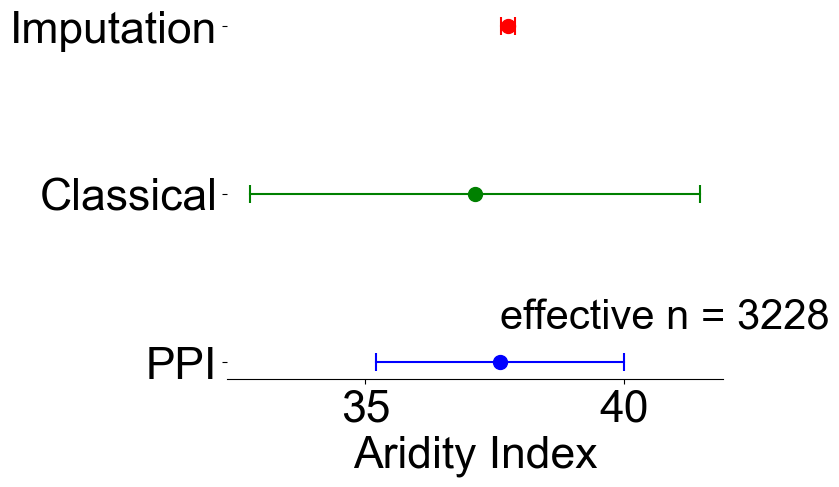

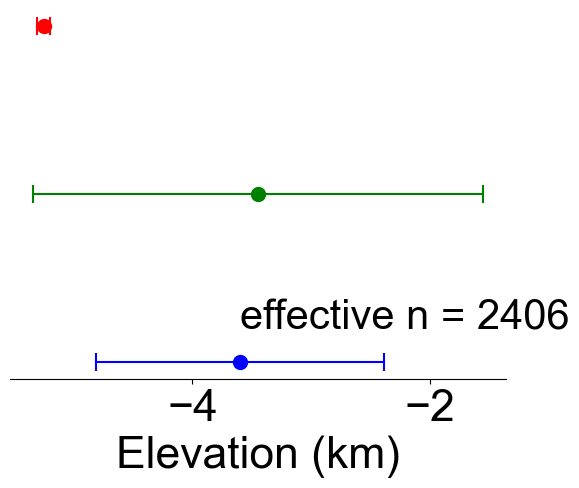

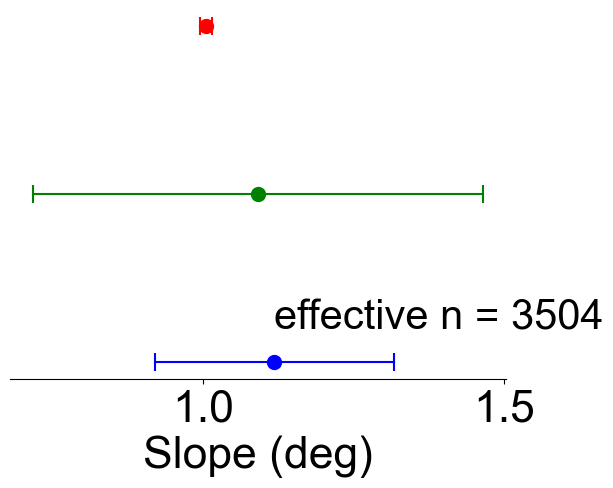

In [9]:
ppi_results = df.loc[(df['method'] == 'PPI')]
ppi_avg_estimates = ppi_results['estimate'].mean(axis=0)
ppi_avg_widths = ppi_results['width'].mean(axis=0)

classical_results = df.loc[(df['method'] == 'Classical')]
classical_avg_estimates = classical_results['estimate'].mean(axis=0)
classical_avg_widths = classical_results['width'].mean(axis=0)

imputation_estimates = df.loc[df['method']=='Imputation']['estimate'].mean(axis=0)
imputation_widths = df.loc[df['method']=='Imputation']['width'].mean(axis=0)

covariates_dict = {'aridity_index': 'Aridity Index', 'elevation': 'Elevation (km)', 'slope': 'Slope (deg)'}

# https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python
colors = ['blue', 'green', 'red']
for i, column in enumerate(covariates):
    data_dict = {}
    ppi_effective_n = int(np.round(Y.shape[0]*(classical_avg_widths[i]/ppi_avg_widths[i])**2))
    data_dict['category'] = [f'PPI',
                             f'Classical',
                             'Imputation']
    data_dict['lower'] = [ppi_avg_estimates[i] - ppi_avg_widths[i]/2, classical_avg_estimates[i] - classical_avg_widths[i]/2, imputation_estimates[i] - imputation_widths[i]/2]
    data_dict['upper'] = [ppi_avg_estimates[i] + ppi_avg_widths[i]/2, classical_avg_estimates[i] + classical_avg_widths[i]/2, imputation_estimates[i] + imputation_widths[i]/2]
    dataset = pd.DataFrame(data_dict)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
        if column in ['elevation']:
            lower = lower*1000
            upper = upper*1000
        plt.scatter([(lower+upper)/2], [y], color=colors[y], s=100)
        plt.scatter([lower, upper], [y, y], color=colors[y], marker='|', s=150)
        plt.plot((lower,upper),(y,y),color=colors[y])
        if y == 0:
            plt.text((lower+upper)/2, 0.2, f'effective n = {ppi_effective_n}', fontsize = 30)
    if i == 0:
        plt.yticks(range(len(dataset)),list(dataset['category']))
    else:
        ax.set_yticks([])
    plt.xlabel(f'{covariates_dict[column]}')
    plt.savefig(f'output_images/tree_cover_lin_reg_{column}.png', dpi=300, bbox_inches='tight')
    plt.show()